## Business understanding

The target business is a accomodation rental service (AirBnB).  
Their business model is acting as a platform for home owners to list their properties for rents, either for long-term stays or short-term touristic purposes.  
Visitors can then leave their reviews for each listing.  
Rental price, review scores, and number of stays can be interesting factors.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.figsize'] = [10,4]

In [128]:
calendar_df = pd.read_csv("calendar.csv")
listings_df = pd.read_csv("listings.csv")
reviews_df = pd.read_csv("reviews.csv")

dfs = [calendar_df, listings_df, reviews_df]
for df in dfs:
    print(df.shape)

(1393570, 4)
(3818, 92)
(84849, 6)


## Data Understanding

The data is for AirBnb listings in the Seattle area, so it may not reflect the overall global AirBnb trend.  
However, it still provides a useful overview of a typical urban and touristic area. 
The data contains the following:

- A list of listings, the date in the year, and the price on that date. The data is from the year 2016
- Details on each listing ids, with multiple attributes like number of bedrooms, size, number of reviews etc.
- Detailed reviews for each listing. this dates as far back as 2012

A few questions can be asked:
- Do higher prices equate better reviews or more reviews?
- Do longer reviews mean the scores are more positive?
- What attributes contribute to a higher rental price?
- Do repeat customers mean higher review scores?

## Some look into seasonal availability

The data from the calendar.csv file promise us a pretty good picture of how prices and listings varied throughout the year.
Before we can gain some insights however, a few cleanup steps are needed:
- The **price** column is not in numeric format, which is not very useful
- The **date** column is still in string format, and also has only days of the year, which may provide a bit too much granularity for our needs

In [4]:
calendar_df_new = pd.concat([calendar_df, pd.get_dummies(calendar_df["available"], dummy_na=True)],axis=1)

calendar_df_new["date"] = pd.to_datetime(calendar_df_new["date"])

# Clean up currency indicators to get proper price

import re
def clean_dollar(price):
    try:
        return float(re.sub(r'[^\d.]','', price))
    except:
        return price
calendar_df_new["price"] = calendar_df_new["price"].apply(clean_dollar)

calendar_df_new["month"] = calendar_df_new["date"].apply(lambda x: x.month)

In [5]:
calendar_df_new.isna().sum()

listing_id         0
date               0
available          0
price         459028
f                  0
t                  0
NaN                0
month              0
dtype: int64

In [6]:
calendar_df_new["available"].value_counts()

t    934542
f    459028
Name: available, dtype: int64

The number of lines with no price matches the number of acommodation-not-available lines, which proposes a strong probability that when an accommodation is not available, there is no price for it. It can be deduced, then, that the meaning of availability is "not up for rent", rather than "is occupied".

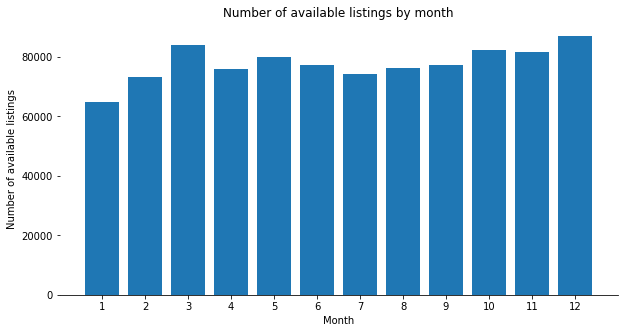

In [7]:
# Number of available listings by month
fig, ax = plt.subplots(figsize=(10,5))
avail_by_month = calendar_df_new.groupby(["month"])["t"].sum()
plt.bar(x=avail_by_month.index, height = avail_by_month, tick_label=avail_by_month.index);
sns.despine(left=True, right=True)
ax.set_title("Number of available listings by month")
plt.xlabel("Month");
plt.ylabel("Number of available listings");

### Findings:
The number of available listings is calculated as the total number of listings marked as available in a specific month.  
A dip can be seen in the period from May to September, which suggests some seasonality, where there is higher demand during the summertime, usually a time of vacation.  
Interestingly, however, the number of available listings in January is much lower than the number of listings in December, which, coupling with the fact that the data is only for 1 year, may denote an overall increase in the number of listings. This makes sense, since 2016 is still a growing year for Airbnb as a platform, and it is easily surmised that the number of users would increase as more and more people turn to the platform for extra income.  
(This may be proven by the total number of listings, which is seen below)

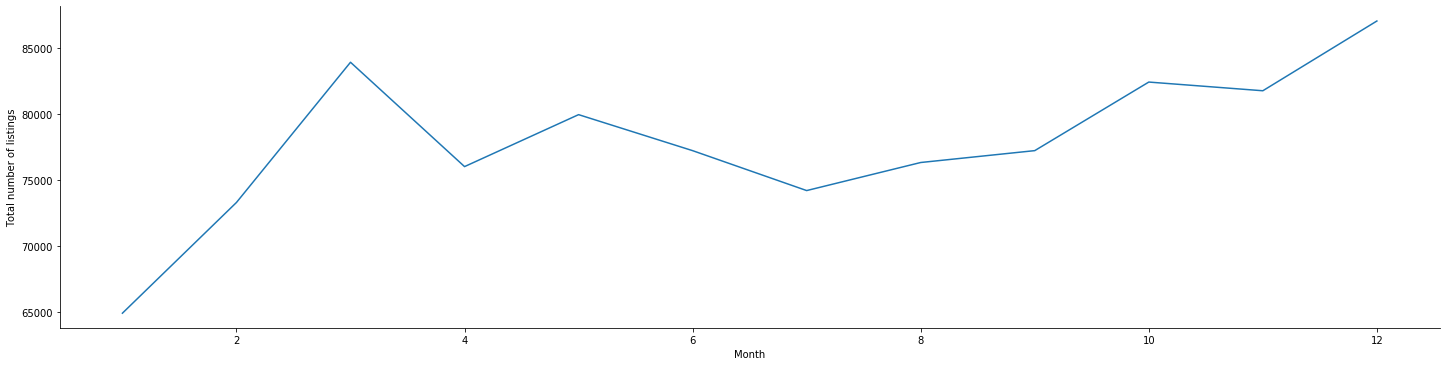

In [8]:
# See the number of listings by day
count_no_listing = calendar_df_new.groupby("month")["price"].count()
sns.relplot(data=count_no_listing, kind="line", height=5, aspect=4);
plt.xlabel("Month");
plt.ylabel("Total number of listings");

As expected! The number of listing increased quite sharply from January to around March, with a few dips from April to July, before enjoying a very steady increase towards the year end.  
(The April to July lull is very interesting, and may have been tied to some negative press that AirBnb was under during the time).

Now let's look at price fluctuation throughout the year through visualizing the average rental price monthly:

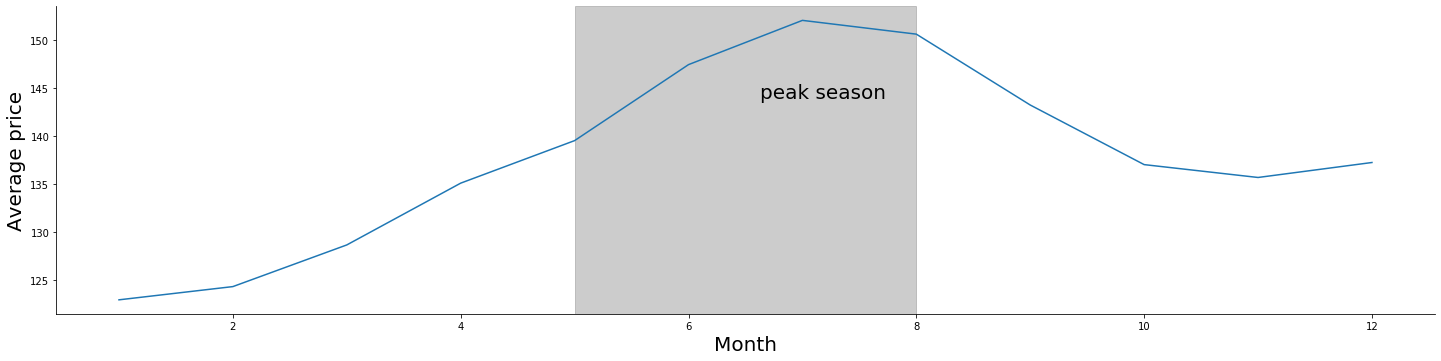

In [30]:

g = sns.relplot(data=calendar_df_new, x="month", y="price", ci=None, kind="line", height=5, aspect=4);
# prices are averaged for each day
plt.xlabel("Month", fontsize=20)
plt.ylabel("Average price", fontsize=20)
plt.axvspan(5,8, alpha=0.4, color="grey")
plt.text(1.2,0.8, "peak season", transform=ax.transAxes, fontsize=20)
plt.show()

The following can be derived from the above:
- Prices increase in the summer from May to Aug, then decrease
- Number of listings do not correspond with increase in price  

While the number of listings do seem to be in steady upward trend, the same cannot be said for the price; in fact, it shows quite clear seasonality, with a steady increase up to the end of the summer months, after which the price decrease steadily, suggesting the slow season start.

## Let's see what the reviews data can tell us

At this point, you might be thinking: "I thought the listing data comes first!". But trust me, you don't wanna tackle that monster, at least not right now. Let's explore the rest of the "lighter" stuff, with less columns to worry about.

In [41]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [42]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


There are some null values in the comments section, which might mean that the reviewer only gave ratings without a written review, but very few it seems. People are passionate about where they stay!  

Let's see if we have some repeaters.

In [54]:
print("The number of visitors staying more than once: ", (reviews_df["reviewer_id"].value_counts() > 1).sum())
print("The most number of stays is ", reviews_df["reviewer_id"].value_counts().max())

The number of visitors staying more than once:  6349
The most number of stays is  67


In [91]:
most_reviewer = reviews_df["reviewer_id"].value_counts().head().index[0]
reviews_df[reviews_df["reviewer_id"]==most_reviewer][reviews_df[reviews_df["reviewer_id"]==most_reviewer]["listing_id"]==reviews_df[reviews_df["reviewer_id"]==most_reviewer].listing_id.value_counts().index[0]]

,listing_id,id,date,reviewer_id,reviewer_name,comments,month
37347,706385,5529162,2013-07-04,206203,Amanda,The sky cabin is my new favorite Seattle place...,7
37365,706385,7987816,2013-10-11,206203,Amanda,Was pleased to find the Sky Cabin available ag...,10
37377,706385,9309423,2013-12-20,206203,Amanda,"The sky cabin is a real treat; great view, com...",12
37382,706385,9789919,2014-01-10,206203,Amanda,I am always happy to see Sky Cabin available f...,1
37386,706385,9997119,2014-01-24,206203,Amanda,When I make my frequent trips to Seattle I loo...,1
37390,706385,10219162,2014-02-07,206203,Amanda,Sky Cabin is a welcome retreat for this weary ...,2
37392,706385,10481855,2014-02-21,206203,Amanda,The Sky Cabin is the best. Treat yourself and ...,2
37402,706385,11470216,2014-04-04,206203,Amanda,I stay here frequently for my Seattle visits a...,4
37434,706385,19375983,2014-09-11,206203,Amanda,I am always pleased to find Gillian's Sky Cabi...,9
37439,706385,21000895,2014-10-09,206203,Amanda,The Sky Cabin is great. I stay there whenever ...,10


Text(0.2, 6759.0, 'Median: 6259.0')

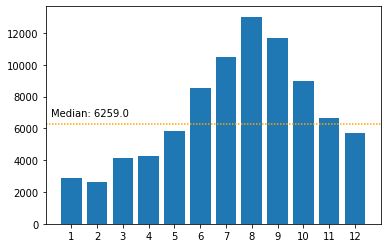

In [23]:
reviews_df["date"] = pd.to_datetime(reviews_df["date"])
reviews_df["month"] = reviews_df["date"].apply(lambda x: x.month)
# Bar chart of review count by month
count_reviews_by_month = reviews_df.groupby("month")["comments"].count()
plt.bar(x=count_reviews_by_month.index, height=count_reviews_by_month, tick_label=count_reviews_by_month.index);
plt.axhline(y=count_reviews_by_month.median(), color="orange", dashes=(1,1))
plt.text(0.2, count_reviews_by_month.median()+500, "Median: %s" %count_reviews_by_month.median())

A clear seasonality can be seen with many more reviews in the summer, which is consistent with our findings from the listing calendar.

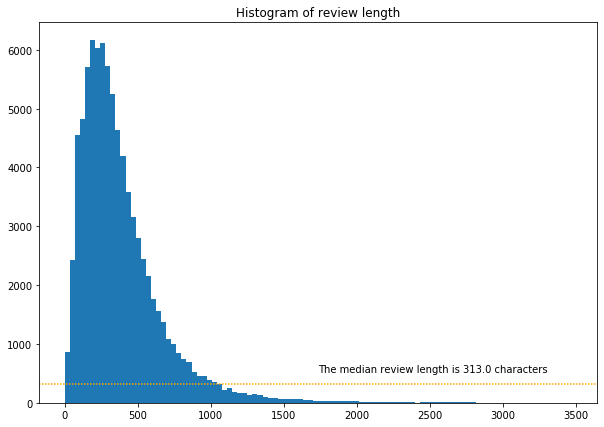

In [269]:
fig, ax = plt.subplots(figsize=(10,7))
review_lengths = reviews_df[reviews_df["comments"].notnull()]["comments"].apply(lambda x: len(x))
ax.hist(review_lengths, bins=100);
ax.axhline(y=review_lengths.median(),color="orange", dashes=(1,1))
ax.set_title("Histogram of review length");
ax.text(0.5,0.08,"The median review length is {} characters".format(review_lengths.median()), transform=ax.transAxes);

No surprises there, most reviews are 200-300 words with a sharp decrease towards longer reviews (honestly, I'm surprised that so many people can even write more than 100 words, but I digress.)

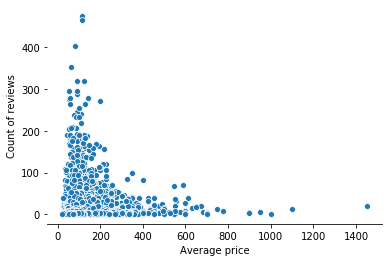

In [36]:
reviews_per_listing = reviews_df.groupby("listing_id")["comments"].count()
average_listing_prices = calendar_df_new.groupby("listing_id")["price"].median()
sns.scatterplot(x=average_listing_prices, y=reviews_per_listing);
sns.despine(left=True);
plt.xlabel("Average price");
plt.ylabel("Count of reviews");

## Listing data deep dive

We are finally getting to the meat and potatoes of the data: the detailed attributes of the listing themselves!  
These will be what we mainly use to suggest listing prices.

Some initial assumptions/hypotheses from looking at data columns:
- Any location columns with less granularity than neighborhood can be removed, since all data is only for a city
- The length of description texts may correlate with the pricing
- The average pricing of properties within a certain radius from the target property may correlate with pricing

In [39]:
listings_df.isna().sum().sort_values(ascending=False)/listings_df.shape[0]

license             1.000000
square_feet         0.974594
monthly_price       0.602672
security_deposit    0.511262
weekly_price        0.473808
                      ...   
accommodates        0.000000
bed_type            0.000000
amenities           0.000000
price               0.000000
id                  0.000000
Length: 92, dtype: float64

In [ ]:
#DATA CLEANUP:
import math

def available_or_not(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: 0 if pd.isna(x) else 1)
url_cols = [col for col in listings_df.columns if "url" in col]
available_or_not(listings_df, url_cols)

for col in ['summary', 'space', 'description','neighborhood_overview', 'notes', 'transit']:
    listings_df[col + "_length"] = listings_df[col].apply(lambda x: len(x) if not pd.isna(x) else x)
    listings_df[col + "_length"] = listings_df[col + "_length"].fillna(0)


# Clean up price cols
price_cols = [col for col in listings_df.select_dtypes(include="object").columns if "$" in listings_df[listings_df[col].notnull()][col].iloc[0]]
for col in price_cols:
    listings_df[col] = listings_df[col].apply(clean_dollar)

#Parameterize the "amenities" column
listings_df.amenities = listings_df.amenities.apply(lambda x: re.sub(r'[{}"]','', x))
amenities_list = ""
for i in listings_df.amenities.apply(lambda x: re.sub(r'[{}"]','', x)):
    amenities_list = amenities_list + ","+ i
amenities_list = set(amenities_list.split(","))
for col in amenities_list:
    listings_df[col] = listings_df.amenities.apply(lambda x: 1 if col in x else 0)
listings_df.drop(columns=["amenities"], inplace=True)

# Booleanize cols and identify cols with single value
bool_cols = []
single_val_cols = []
for col in listings_df.columns:
    value_list = list(listings_df[col].value_counts().index)
    if value_list == ["f", "t"] or value_list == ["t", "f"]:
        bool_cols.append(col)
    elif len(value_list) <= 1:
        single_val_cols.append(col)
        
def booleanize(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: 1 if x == "t" else 0)
booleanize(listings_df, bool_cols)

License column has no value so it can be removed. Nobody needs licenses when using AirBnb it seems.   

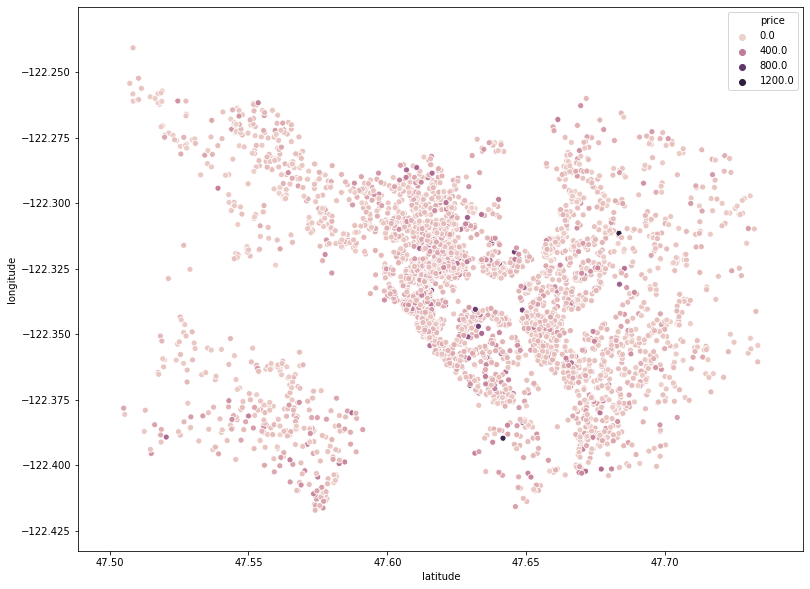

In [272]:
fig, ax = plt.subplots(figsize=(13,10))
sns.scatterplot(data=listings_df, x="latitude", y="longitude", hue="price");

A quite matching picture of Seattle just from the distribution of listings across the city.  
AirBnb must be popular everywhere in this city.  
Also, it seems there are no price hotspots in the city, with price outliers dotting around throughout.

In [ ]:
# Remove cols for final cleanup
meaningless_cols = ["name",'summary', 'space', 'description','neighborhood_overview', 'notes', 
                    'transit','host_id', 'host_url','host_name','host_location', 'host_about', 'host_neighbourhood', 'city', 'state','smart_location','neighbourhood','neighbourhood_group_cleansed',
                   "weekly_price", "monthly_price", "first_review","last_review"]

In [162]:
bool_cols = []
single_val_cols = []
for col in listings_df.columns:
    value_list = list(listings_df[col].value_counts().index)
    if value_list == ["f", "t"] or value_list == ["t", "f"]:
        bool_cols.append(col)
    elif len(value_list) <= 1:
        single_val_cols.append(col)

In [163]:
bool_cols

['host_has_profile_pic', 'host_identity_verified', 'is_location_exact']

In [164]:
def booleanize(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: 1 if x == "t" else 0)
booleanize(listings_df, bool_cols)

C:\Users\vuanh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [134]:
listings_df = listings_df[[col for col in listings_df.columns if col not in single_val_cols]]

In [148]:
import math
def available_or_not(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: 0 if pd.isna(x) else 1)
url_cols = [col for col in listings_df.columns if "url" in col]
available_or_not(listings_df, url_cols)

C:\Users\vuanh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [151]:
listings_df[url_cols].sum()

listing_url           3818
thumbnail_url         3498
medium_url            3498
picture_url           3818
xl_picture_url        3498
host_url              3818
host_thumbnail_url    3816
host_picture_url      3816
dtype: int64

In [90]:
all_summaries = ""
for i in range(listings_df.shape[0]):
    all_summaries = all_summaries + str(listings_df.summary[i])
all_summaries = all_summaries.split(" ")
all_summaries = pd.Series(all_summaries)
all_summaries.value_counts()[31:100]

The         441
just        434
your        431
all         430
heart       425
           ... 
coffee      213
Space       211
spacious    196
within      195
best        194
Length: 69, dtype: int64

In [158]:
def binnize(val):
    if val <= 10:
        return "0-10"
    elif val <= 20:
        return "11-20"
    elif val <= 30:
        return "21-30"
    elif val <= 40:
        return "31-40"
    elif val <= 50:
        return "41-50"
    else:
        return ">50"


In [161]:
listings_df["host_identity_verified"].value_counts()

t    2997
f     819
Name: host_identity_verified, dtype: int64

In [247]:
listings_df.groupby("calendar_updated")["price"].mean().sort_values(ascending=False)
calendar_updated_order = [1,2]

calendar_updated
13 months ago    700.000000
6 months ago     179.931034
12 months ago    163.200000
5 months ago     163.175824
8 months ago     162.357143
4 months ago     144.729323
today            144.284703
22 months ago    140.000000
7 months ago     137.086957
2 months ago     132.348754
7 weeks ago      131.111111
3 weeks ago      130.523333
9 months ago     129.142857
5 days ago       127.909091
4 weeks ago      124.046948
5 weeks ago      123.878205
2 weeks ago      122.749280
10 months ago    121.625000
a week ago       120.447581
3 months ago     119.688073
never            119.375000
yesterday        115.199134
6 weeks ago      111.737288
6 days ago       109.428571
4 days ago       109.296552
1 week ago       106.346154
3 days ago       104.679012
2 days ago       100.104167
16 months ago    100.000000
17 months ago    100.000000
30 months ago    100.000000
11 months ago     97.600000
14 months ago     85.000000
15 months ago     59.000000
Name: price, dtype: float64

There doesn't seem to be any relationship between when the calendar was updated vs average price, so this can be dropped.

In [253]:
for col in listings_df.select_dtypes(include="object").columns:
    print(col + ": ", len(listings_df[col].value_counts().index))

name:  3792
summary:  3478
space:  3119
description:  3742
neighborhood_overview:  2506
notes:  1999
transit:  2574
host_name:  1466
host_since:  1380
host_location:  120
host_about:  2011
host_response_time:  4
host_response_rate:  45
host_acceptance_rate:  2
host_neighbourhood:  102
host_verifications:  116
street:  1442
neighbourhood:  81
neighbourhood_cleansed:  87
neighbourhood_group_cleansed:  17
city:  7
state:  2
zipcode:  28
smart_location:  7
property_type:  16
room_type:  3
bed_type:  5
calendar_updated:  34
first_review:  984
last_review:  321
cancellation_policy:  3


In [254]:
meaningless_cols = ["name",'summary', 'space', 'description','neighborhood_overview', 'notes', 
                    'transit','host_id', 'host_url','host_name','host_location', 'host_about', 'host_neighbourhood', 'city', 'state','smart_location','neighbourhood','neighbourhood_group_cleansed',
                   "weekly_price", "monthly_price", "first_review","last_review"]

0        Queen Anne
1        Queen Anne
2        Queen Anne
3        Queen Anne
4        Queen Anne
           ...     
3813          Holly
3814    Portage Bay
3815            NaN
3816            NaN
3817     Queen Anne
Name: host_neighbourhood, Length: 3818, dtype: object

In [255]:
listings_df.host_acceptance_rate

0       100%
1       100%
2       100%
3        NaN
4        NaN
        ... 
3813    100%
3814    100%
3815     NaN
3816     NaN
3817     NaN
Name: host_acceptance_rate, Length: 3818, dtype: object